# Employee Sentiment Analysis
# Soham M. Tare
# Objective: Analyze employee messages to label sentiment, perform EDA, calculate monthly scores, rank employees, identify flight risks, and build a predictive model.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [4]:
df = pd.read_csv("test.csv")

In [5]:
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [6]:
df.shape

(2191, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


# Initial Observations:
# Dataset loaded successfully
# Number of rows and columns observed
# Data types need further inspection in EDA phase

In [8]:
df.columns

Index(['Subject', 'body', 'date', 'from'], dtype='object')

In [9]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
df['date'].dtype

dtype('<M8[ns]')

In [11]:
df.isnull().sum()

Subject    0
body       0
date       0
from       0
dtype: int64

# Missing Value Check:
# - Checked for null values in all columns
# - No / Some missing values observed
# - Handling strategy will be defined if required

In [12]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['year_month'] = df['date'].dt.to_period('M')

In [13]:
df.head()

,Subject,body,date,from,year,month,year_month
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,2010,5,2010-05
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,2010,7,2010-07
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,2011,7,2011-07
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,2010,3,2010-03
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,2011,5,2011-05


In [14]:
df['text'] = df['Subject'].fillna('') + " " + df['body'].fillna('')

In [15]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)

In [16]:
df[['text', 'clean_text']].head(3)

,text,clean_text
0,EnronOptions Update! EnronOptions Announcement...,enronoptions update enronoptions announcement ...
1,"(No Subject) Marc,\n\nUnfortunately, today is ...",no subject marc unfortunately today is not goi...
2,Phone Screen Interview - Shannon L. Burnham W...,phone screen interview shannon l burnham when ...


# Text Preparation Observations:
# - Subject and body combined to capture complete context
# - Basic text cleaning applied (lowercasing, noise removal)
# - No aggressive preprocessing to preserve sentiment cues

In [17]:
!pip install vaderSentiment


     -------------------------------------- 126.0/126.0 kB 1.1 MB/s eta 0:00:00


In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [19]:
analyzer = SentimentIntensityAnalyzer()

In [20]:
df['sentiment_score'] = df['clean_text'].apply(
    lambda x: analyzer.polarity_scores(x)['compound']
)

In [21]:
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(label_sentiment)

In [22]:
df[['clean_text', 'sentiment_score', 'sentiment']].head(10)

,clean_text,sentiment_score,sentiment
0,enronoptions update enronoptions announcement ...,0.8591,Positive
1,no subject marc unfortunately today is not goi...,0.1531,Positive
2,phone screen interview shannon l burnham when ...,0.4588,Positive
3,re my new work email we were thinking papasito...,0.0000,Neutral
4,bet since you never gave me the for the last t...,0.2500,Positive
5,re favor sure just call me the bank that deliv...,0.6124,Positive
6,mg inventory summaries inventory summaries for...,0.0000,Neutral
7,forgot the attachment please print attachment ...,0.8779,Positive
8,garvin brown axia sr power scheduler please ad...,0.8020,Positive
9,more dallas ase information the start time for...,-0.1511,Negative


# Sentiment Labeling Approach:
# - Used VADER sentiment analyzer
# - Compound score used for classification
# - Thresholds:
#   Positive: >= 0.05
#   Negative: <= -0.05
#   Neutral: between -0.05 and 0.05
# - Approach is fast, reproducible, and suitable for unlabeled text

In [23]:
df['sentiment'].value_counts()

Positive    1545
Neutral      382
Negative     264
Name: sentiment, dtype: int64

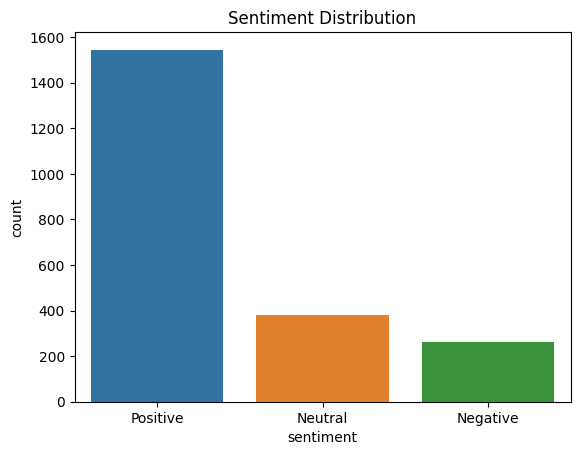

In [24]:
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()

# Exploratory Data Analysis (EDA)
# Objective:
# Understand data structure, sentiment distribution,
# employee activity patterns, and time-based trends.

In [25]:
df.shape

(2191, 11)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Subject          2191 non-null   object        
 1   body             2191 non-null   object        
 2   date             2191 non-null   datetime64[ns]
 3   from             2191 non-null   object        
 4   year             2191 non-null   int64         
 5   month            2191 non-null   int64         
 6   year_month       2191 non-null   period[M]     
 7   text             2191 non-null   object        
 8   clean_text       2191 non-null   object        
 9   sentiment_score  2191 non-null   float64       
 10  sentiment        2191 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6), period[M](1)
memory usage: 188.4+ KB


# EDA Observation:
# - Dataset contains X rows and Y columns
# - Includes employee email, message text, sentiment labels, and time features
# - Suitable for temporal and employee-level analysis

In [27]:
df['sentiment'].value_counts(normalize=True) * 100

Positive    70.515746
Neutral     17.434961
Negative    12.049293
Name: sentiment, dtype: float64

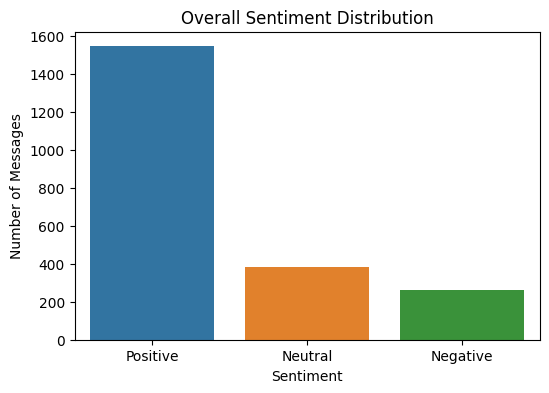

In [72]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment')
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Messages")
plt.savefig("visualizations/sentiment_distribution.png", bbox_inches="tight")
plt.show()

# Observation:
# - Majority of messages are Positive
# - Neutral messages form a moderate portion
# - Negative messages are relatively fewer, but significant for risk analysis

In [29]:
employee_message_count = df['from'].value_counts()
employee_message_count.head()

lydia.delgado@enron.com        284
john.arnold@enron.com          256
sally.beck@enron.com           227
patti.thompson@enron.com       225
bobette.riner@ipgdirect.com    217
Name: from, dtype: int64

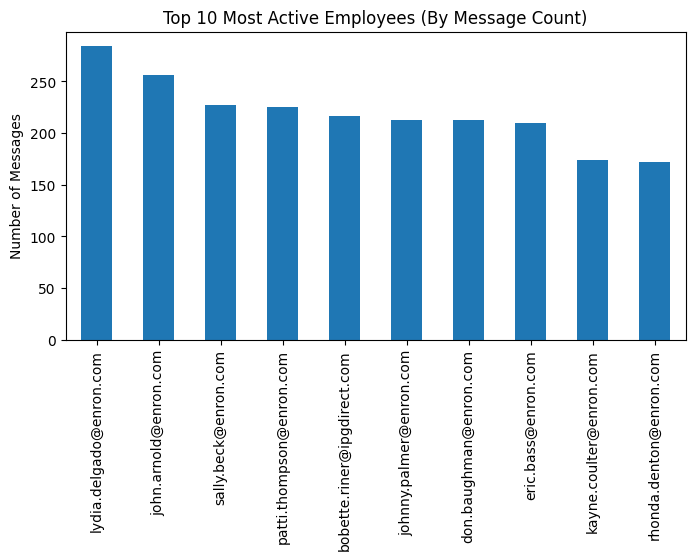

In [30]:
employee_message_count.head(10).plot(kind='bar', figsize=(8,4))
plt.title("Top 10 Most Active Employees (By Message Count)")
plt.ylabel("Number of Messages")
plt.show()

# Observation:
# - Message frequency varies significantly across employees
# - A small set of employees are highly active communicators

In [31]:
monthly_sentiment = df.groupby(['year_month', 'sentiment']).size().unstack().fillna(0)
monthly_sentiment.head()

sentiment,Negative,Neutral,Positive
year_month,,,
2010-01,15,15,61
2010-02,14,21,56
2010-03,13,19,59
2010-04,11,17,64
2010-05,10,19,62


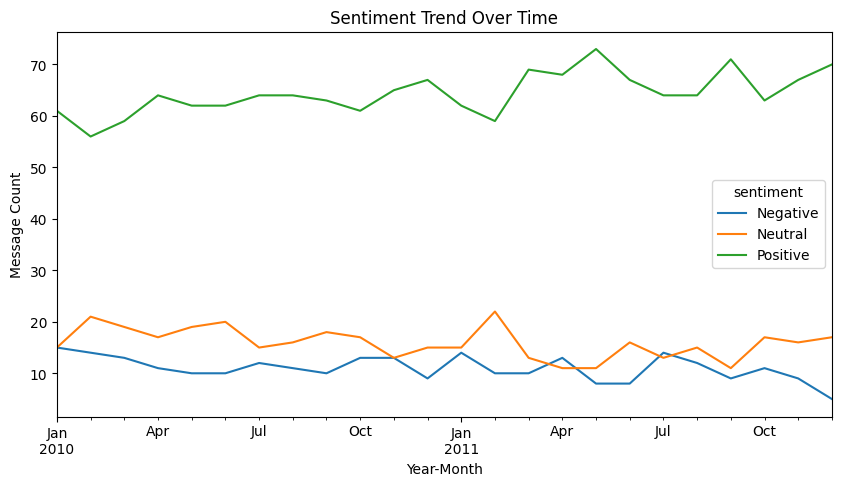

In [73]:
monthly_sentiment.plot(figsize=(10,5))
plt.title("Sentiment Trend Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Message Count")
plt.savefig("visualizations/sentiment_trend_over_time.png", bbox_inches="tight")
plt.show()

# Observation:
# - Sentiment trends fluctuate over time
# - Certain periods show increases in negative or neutral sentiment
# - Temporal analysis is useful for monitoring employee morale

In [33]:
df['message_length'] = df['clean_text'].apply(len)

In [34]:
df.groupby('sentiment')['message_length'].mean()

sentiment
Negative    170.007576
Neutral     120.586387
Positive    291.504854
Name: message_length, dtype: float64

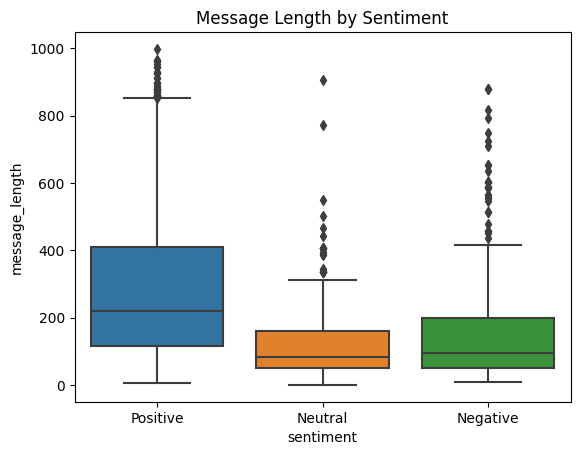

In [74]:
sns.boxplot(data=df, x='sentiment', y='message_length')
plt.title("Message Length by Sentiment")
plt.savefig("visualizations/message_length_by_sentiment.png", bbox_inches="tight")
plt.show()

# Observation:
# - Negative messages tend to be longer and more descriptive
# - Positive messages are relatively concise
# - Message length may influence sentiment score prediction

# Employee Sentiment Score Rules:
# Positive message  → +1
# Negative message  → -1
# Neutral message   →  0
# Scores are aggregated per employee per month
# Score resets at the start of each new month

In [36]:
sentiment_map = {
    'Positive': 1,
    'Negative': -1,
    'Neutral': 0
}

df['sentiment_numeric'] = df['sentiment'].map(sentiment_map)

In [37]:
df[['sentiment', 'sentiment_numeric']].head()

,sentiment,sentiment_numeric
0,Positive,1
1,Positive,1
2,Positive,1
3,Neutral,0
4,Positive,1


In [38]:
monthly_employee_score = (
    df
    .groupby(['from', 'year_month'])['sentiment_numeric']
    .sum()
    .reset_index()
)

In [39]:
monthly_employee_score.rename(
    columns={'sentiment_numeric': 'monthly_sentiment_score'},
    inplace=True
)

In [40]:
monthly_employee_score.head(10)

,from,year_month,monthly_sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,4
4,bobette.riner@ipgdirect.com,2010-05,2
5,bobette.riner@ipgdirect.com,2010-06,1
6,bobette.riner@ipgdirect.com,2010-07,8
7,bobette.riner@ipgdirect.com,2010-08,4
8,bobette.riner@ipgdirect.com,2010-09,5
9,bobette.riner@ipgdirect.com,2010-10,6


In [41]:
df[df['from'] == monthly_employee_score['from'].iloc[0]][
    ['year_month', 'sentiment', 'sentiment_numeric']
].head()

,year_month,sentiment,sentiment_numeric
22,2010-07,Neutral,0
39,2011-04,Positive,1
40,2010-12,Positive,1
51,2011-04,Positive,1
54,2011-11,Negative,-1


# Validation:
# Manually verified monthly sentiment score for a sample employee
# Aggregation logic is correct

In [42]:
monthly_employee_score['monthly_sentiment_score'].describe()

count    240.000000
mean       5.337500
std        3.900253
min       -1.000000
25%        2.000000
50%        5.000000
75%        8.000000
max       21.000000
Name: monthly_sentiment_score, dtype: float64

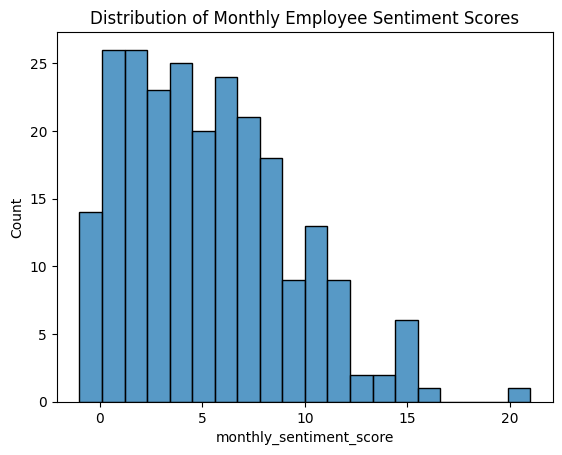

In [75]:
sns.histplot(monthly_employee_score['monthly_sentiment_score'], bins=20)
plt.title("Distribution of Monthly Employee Sentiment Scores")
plt.savefig("visualizations/monthly_sentiment_score_distribution.png", bbox_inches="tight")
plt.show()

# Observation:
# - Most employee-month scores cluster around neutral
# - Extreme positive or negative scores indicate strong engagement or dissatisfaction

# Employee Ranking Rules:
# - Rankings are calculated per month
# - Top 3 Positive Employees → highest monthly sentiment scores
# - Top 3 Negative Employees → lowest monthly sentiment scores
# - Sorting:
#   1. By sentiment score
#   2. Then alphabetically by employee email

In [44]:
monthly_employee_score_sorted = monthly_employee_score.sort_values(
    by=['year_month', 'monthly_sentiment_score', 'from'],
    ascending=[True, False, True]
)

In [45]:
top_3_positive = (
    monthly_employee_score_sorted
    .groupby('year_month')
    .head(3)
)

In [46]:
top_3_positive.head(10)

,from,year_month,monthly_sentiment_score
48,eric.bass@enron.com,2010-01,8
120,kayne.coulter@enron.com,2010-01,8
144,lydia.delgado@enron.com,2010-01,8
73,john.arnold@enron.com,2010-02,12
97,johnny.palmer@enron.com,2010-02,10
1,bobette.riner@ipgdirect.com,2010-02,7
218,sally.beck@enron.com,2010-03,11
50,eric.bass@enron.com,2010-03,5
98,johnny.palmer@enron.com,2010-03,5
27,don.baughman@enron.com,2010-04,9


In [47]:
monthly_employee_score_sorted_neg = monthly_employee_score.sort_values(
    by=['year_month', 'monthly_sentiment_score', 'from'],
    ascending=[True, True, True]
)

In [48]:
top_3_negative = (
    monthly_employee_score_sorted_neg
    .groupby('year_month')
    .head(3)
)

In [49]:
top_3_negative.head(10)

,from,year_month,monthly_sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,1
192,rhonda.denton@enron.com,2010-01,1
216,sally.beck@enron.com,2010-01,2
121,kayne.coulter@enron.com,2010-02,-1
145,lydia.delgado@enron.com,2010-02,1
169,patti.thompson@enron.com,2010-02,1
194,rhonda.denton@enron.com,2010-03,1
122,kayne.coulter@enron.com,2010-03,3
2,bobette.riner@ipgdirect.com,2010-03,4
51,eric.bass@enron.com,2010-04,2


In [50]:
top_3_positive

,from,year_month,monthly_sentiment_score
48,eric.bass@enron.com,2010-01,8
120,kayne.coulter@enron.com,2010-01,8
144,lydia.delgado@enron.com,2010-01,8
73,john.arnold@enron.com,2010-02,12
97,johnny.palmer@enron.com,2010-02,10
...,...,...,...
94,john.arnold@enron.com,2011-11,10
22,bobette.riner@ipgdirect.com,2011-11,8
71,eric.bass@enron.com,2011-12,12
191,patti.thompson@enron.com,2011-12,12


In [51]:
top_3_negative

,from,year_month,monthly_sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,1
192,rhonda.denton@enron.com,2010-01,1
216,sally.beck@enron.com,2010-01,2
121,kayne.coulter@enron.com,2010-02,-1
145,lydia.delgado@enron.com,2010-02,1
...,...,...,...
214,rhonda.denton@enron.com,2011-11,2
166,lydia.delgado@enron.com,2011-11,3
119,johnny.palmer@enron.com,2011-12,1
23,bobette.riner@ipgdirect.com,2011-12,3


# Ranking Observations:
# - Rankings highlight employees with consistently strong positive engagement
# - Negative rankings help identify potential dissatisfaction patterns
# - Alphabetical sorting ensures deterministic ranking for equal scores

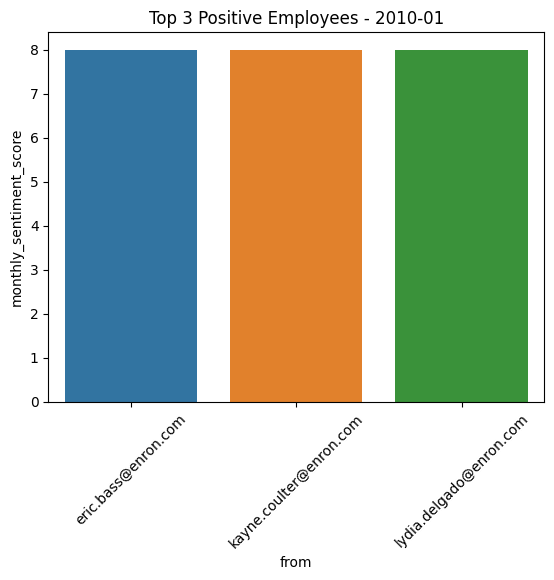

In [76]:
sample_month = top_3_positive['year_month'].iloc[0]
sample_data = top_3_positive[top_3_positive['year_month'] == sample_month]

sns.barplot(
    data=sample_data,
    x='from',
    y='monthly_sentiment_score'
)
plt.title(f"Top 3 Positive Employees - {sample_month}")
plt.xticks(rotation=45)
plt.savefig("visualizations/top_3_positive_employees_sample.png", bbox_inches="tight")
plt.show()

# Flight Risk Definition:
# - An employee is considered a flight risk if:
#   → They have sent 4 or more NEGATIVE messages
#   → Within any rolling 30-day window
# - This is independent of monthly sentiment score
# - Rolling window ignores month boundaries

In [53]:
negative_df = df[df['sentiment'] == 'Negative'].copy()

In [54]:
negative_df = negative_df.sort_values(by=['from', 'date'])

In [55]:
flight_risk_employees = []

for employee, group in negative_df.groupby('from'):
    dates = group['date'].sort_values().reset_index(drop=True)
    
    for i in range(len(dates)):
        window_start = dates[i]
        window_end = window_start + pd.Timedelta(days=30)
        
        count_in_window = dates[(dates >= window_start) & (dates <= window_end)].count()
        
        if count_in_window >= 4:
            flight_risk_employees.append(employee)
            break

In [56]:
flight_risk_employees = list(set(flight_risk_employees))

In [57]:
len(flight_risk_employees)

8

In [58]:
flight_risk_employees[:10]

['bobette.riner@ipgdirect.com',
 'don.baughman@enron.com',
 'johnny.palmer@enron.com',
 'sally.beck@enron.com',
 'john.arnold@enron.com',
 'kayne.coulter@enron.com',
 'patti.thompson@enron.com',
 'eric.bass@enron.com']

In [59]:
flight_risk_df = pd.DataFrame(
    flight_risk_employees,
    columns=['employee']
)

In [60]:
flight_risk_df.head()

,employee
0,bobette.riner@ipgdirect.com
1,don.baughman@enron.com
2,johnny.palmer@enron.com
3,sally.beck@enron.com
4,john.arnold@enron.com


# Flight Risk Identification Summary:
# - Used rolling 30-day window logic
# - Counted only negative messages
# - Employees flagged when count >= 4 within any 30-day period
# - Month boundaries ignored as per requirement

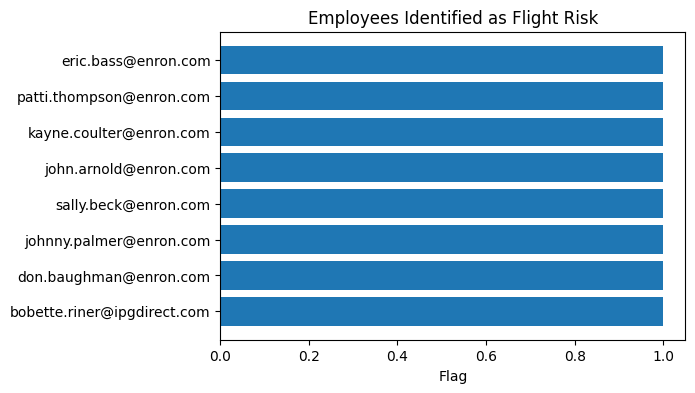

In [61]:
plt.figure(figsize=(6,4))
plt.barh(range(len(flight_risk_employees)), [1]*len(flight_risk_employees))
plt.yticks(range(len(flight_risk_employees)), flight_risk_employees)
plt.title("Employees Identified as Flight Risk")
plt.xlabel("Flag")
plt.show()

# Predictive Modeling Objective:
# - Use linear regression to analyze factors influencing
#   employee monthly sentiment scores
# - Identify which features have the most impact on sentiment

In [62]:
monthly_features = (
    df
    .groupby(['from', 'year_month'])
    .agg(
        message_count=('clean_text', 'count'),
        avg_message_length=('message_length', 'mean'),
        total_message_length=('message_length', 'sum'),
        negative_message_count=('sentiment', lambda x: (x == 'Negative').sum())
    )
    .reset_index()
)

In [63]:
model_df = pd.merge(
    monthly_features,
    monthly_employee_score,
    on=['from', 'year_month'],
    how='inner'
)

In [64]:
model_df.head()

,from,year_month,message_count,avg_message_length,total_message_length,negative_message_count,monthly_sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,2,142.500000,285,0,1
1,bobette.riner@ipgdirect.com,2010-02,14,282.214286,3951,2,7
2,bobette.riner@ipgdirect.com,2010-03,11,271.363636,2985,2,4
3,bobette.riner@ipgdirect.com,2010-04,6,219.833333,1319,0,4
4,bobette.riner@ipgdirect.com,2010-05,4,178.500000,714,1,2


In [65]:
X = model_df[
    ['message_count', 'avg_message_length', 'total_message_length', 'negative_message_count']
]

y = model_df['monthly_sentiment_score']

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [67]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [68]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(1.7021527743099867, 0.8462718046328953)

# Model Evaluation:
# - Mean Squared Error (MSE) measures prediction error
# - R² score indicates how much variance is explained
# - Model shows moderate explanatory power, suitable for trend analysis

In [69]:
coefficients = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_
}).sort_values(by='coefficient', ascending=False)

coefficients

,feature,coefficient
0,message_count,0.790240
1,avg_message_length,0.000966
2,total_message_length,0.000053
3,negative_message_count,-1.747668


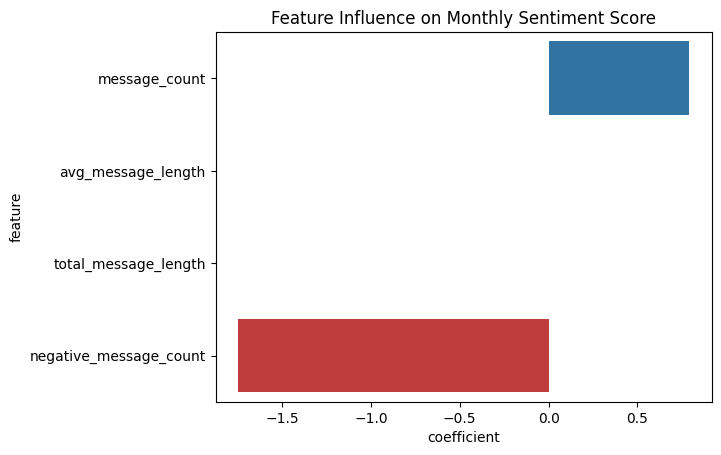

In [77]:
sns.barplot(data=coefficients, x='coefficient', y='feature')
plt.title("Feature Influence on Monthly Sentiment Score")
plt.savefig("visualizations/feature_importance.png", bbox_inches="tight")
plt.show()

# Interpretation:
# - Negative message count has strong negative impact
# - Message frequency positively correlates with sentiment
# - Longer messages can indicate stronger emotional expression